In [21]:
%matplotlib inline
import os
import numpy as np
import json
from ultralytics.engine.results import Results
from tqdm import tqdm

from inference import Detector, Classificator, Inference
from inference.Inference import quantify 

# object detection
from utils.data import as_coco
from utils.data.load import load_yolo, loader
from utils.metrics.coco import CocoEvaluator
from utils.metrics.utils import get_classify_ground_truth

from sklearn.metrics import (
    # classification,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    # qunatification    
    explained_variance_score,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
config = {
    "val_source": "../datasets/orobanche_cummana/autosplit_val.txt",
    "detect_model_path": os.path.normpath("./runs/detect/train2/weights/best.pt"),
    "classify_model_path": os.path.normpath("./runs/classify/train/weights/best.pt"),
    'results': 'results',
    
    "classes": {
      0: "background",
      1: "healthy",
      2: "necrotic",  
    },
    #DETECTION
    "device": 0,
    "overlap": 0.2,
    "patch_size": 1024,
    "size_factor": 1.0,
    "conf_thresh": 0.25,
    "nms_iou_thresh":  0.7,
    "max_patch_detections": 300,
    "patch_per_batch": 4,
    "pre_wbf_detections":  3000,
    "wbf_ios_thresh": 0.5,
    "max_detections": 1000,
    
    #CLASSIFICATION (INFERENCE)
    "offset": 0.2,
    "classify_img_size": 224,
    
    #CLASSIFICATION (EVALUATION)
    "bg_iou_thresh": 0.7,
}

In [8]:
detection_gt = load_yolo(config["val_source"])
for key, value in detection_gt.items():
    detection_gt[key] = np.asarray(value)
    
coco_gt_detection, names_to_ids  = as_coco(detection_gt, config["classes"])

coco_detection_evaluator = CocoEvaluator(coco_gt_detection)

In [9]:
detect = Detector(
    model_path=config["detect_model_path"],
    device=config["device"],
    overlap=config["overlap"],
    patch_size=config["patch_size"],
    size_factor=config["size_factor"],
    conf_thresh=config["conf_thresh"],
    nms_iou_thresh=config["nms_iou_thresh"],
    max_patch_detections=config["max_patch_detections"],
    patch_per_batch=config["patch_per_batch"],
    pre_wbf_detections=config["pre_wbf_detections"],
    wbf_ios_thresh=config["wbf_ios_thresh"],
    max_detections=config["max_detections"],
    single_cls=True,
)

classify = Classificator(
    model_path=config["classify_model_path"], device=config["device"], img_size=config["classify_img_size"],
)

inference = Inference(detect,classify,offset=config['offset'])

In [10]:
detect_predictions: dict[str, Results] = {}
classify_predictions: dict[str, list]  = {}
inference_predictions: dict[str, Results] = {}
quantification_predictions = {}

quantification_gt = {}
classify_gt = {}

class_num = len(config["classes"])

for image_name, image in tqdm(loader(config["val_source"])):
    detect_predictions[image_name] = inference.detect(image)
    patched_images, patches = inference.patch(image, detect_predictions[image_name].boxes)
    #POTENTIAL BUG -> if no patches are detected, the classify_predictions will be empty
    if patches:
        classify_predictions[image_name], confidences = inference.classify(patched_images)
        classify_gt[image_name] = get_classify_ground_truth(
            detect_predictions[image_name].boxes.xyxy,
            detection_gt[image_name][:,:4],
            detection_gt[image_name][:,4],
            config["bg_iou_thresh"]
        )
        inference_predictions[image_name] = inference.merge_detect_and_classification(image,
                                                                                detect_predictions[image_name].boxes.data,
                                                                                classify_predictions[image_name],
                                                                                confidences
                                                                                )
        quantification_gt[image_name] = quantify(detection_gt[image_name][:, :4],
                                             detection_gt[image_name][:, 4],
                                             class_num,)
        quantification_predictions[image_name] = quantify(inference_predictions[image_name].boxes.xyxy,
                                                      inference_predictions[image_name].boxes.cls,
                                                      class_num,)
    else:
        classify_predictions[image_name] = []
        classify_gt[image_name] = []
        inference_predictions[image_name] = {}
        quantification_gt[image_name] = {}
        quantification_predictions[image_name] = {}
        quantification_gt[image_name]["areas"] = np.zeros((len(config["classes"]),), dtype=np.float64)
        quantification_gt[image_name]["counts"] = np.zeros((len(config["classes"]),), dtype=np.uint64)
        quantification_predictions[image_name]["areas"] = np.zeros((len(config["classes"]),), dtype=np.float64)
        quantification_predictions[image_name]["counts"] = np.zeros((len(config["classes"]),), dtype=np.uint64)
        
    
 
classify_predictions_flat = []
classify_gt_flat = []

for image_name, predicts in classify_predictions.items():
    assert len(predicts) == len(classify_gt[image_name]), f"Image {image_name} has different number of predictions and gt"
    classify_predictions_flat.extend(predicts)
    classify_gt_flat.extend(classify_gt[image_name])
    


quantification_gt_flat = {"areas": np.zeros((len(quantification_gt), class_num), dtype=np.float64), 
                          "counts": np.zeros((len(quantification_gt), class_num), dtype=np.uint64)}
quantification_predictions_flat = {"areas": np.zeros((len(quantification_predictions), class_num), dtype=np.float64), 
                                   "counts": np.zeros((len(quantification_predictions), class_num), dtype=np.uint64)}

for idx, image_name in enumerate(quantification_gt.keys()):
    gt = quantification_gt[image_name]
    pred = quantification_predictions[image_name]
    
    quantification_gt_flat["areas"][idx, :] = gt["areas"]
    quantification_gt_flat["counts"][idx, :] = gt["counts"]
    
    quantification_predictions_flat["areas"][idx, :] = pred["areas"]
    quantification_predictions_flat["counts"][idx, :] = pred["counts"]


88it [38:42, 26.39s/it]


Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.96s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

C:\Users\maksi\AppData\Local\Temp\ipykernel_25556\1260049535.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ap_metrics.keys()), y=list(ap_metrics.values()), palette="coolwarm")


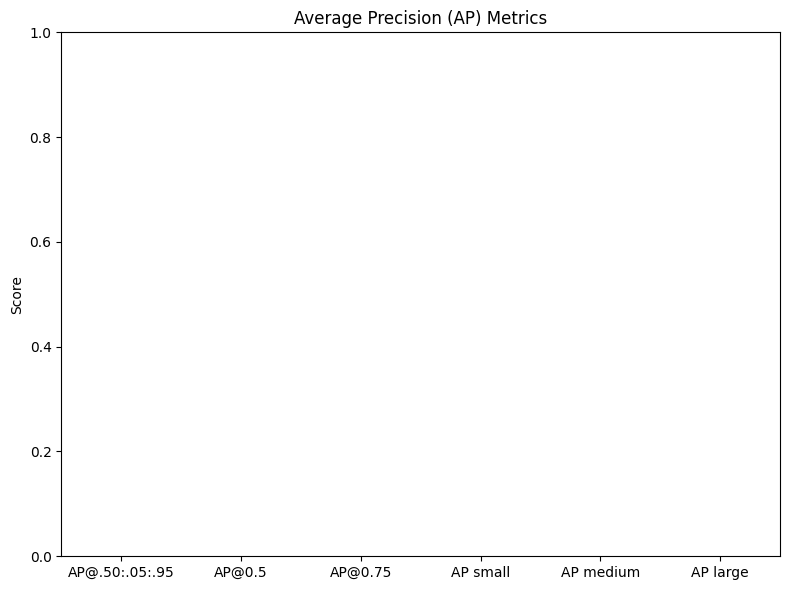

C:\Users\maksi\AppData\Local\Temp\ipykernel_25556\1260049535.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ar_metrics.keys()), y=list(ar_metrics.values()), palette="viridis")


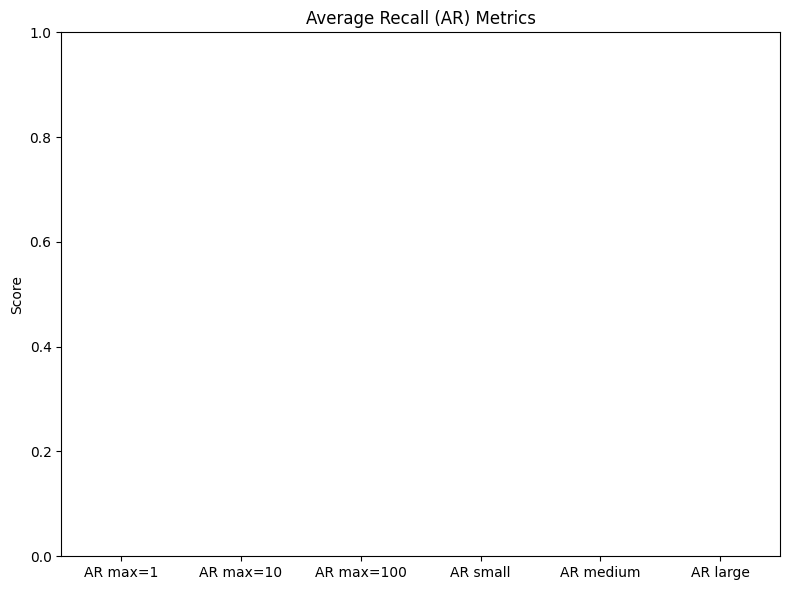

In [ ]:
detect_results = coco_detection_evaluator.eval(detect_predictions, names_to_ids, useCats=False)

os.makedirs(config['results'], exist_ok=True)

with open(os.path.join(config['results'], 'detect_coco'), "w") as f:
    json.dump(config, f, indent=4)
    

# Separate AP and AR metrics for better visualization
ap_metrics = {k: v for k, v in detect_results.items() if k.startswith("AP")}
ar_metrics = {k: v for k, v in detect_results.items() if k.startswith("AR")}

# Plot AP metrics
plt.figure(figsize=(8, 6))
sns.barplot(x=list(ap_metrics.keys()), y=list(ap_metrics.values()))
plt.title("Average Precision (AP) Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot AR metrics
plt.figure(figsize=(8, 6))
sns.barplot(x=list(ar_metrics.keys()), y=list(ar_metrics.values()))
plt.title("Average Recall (AR) Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


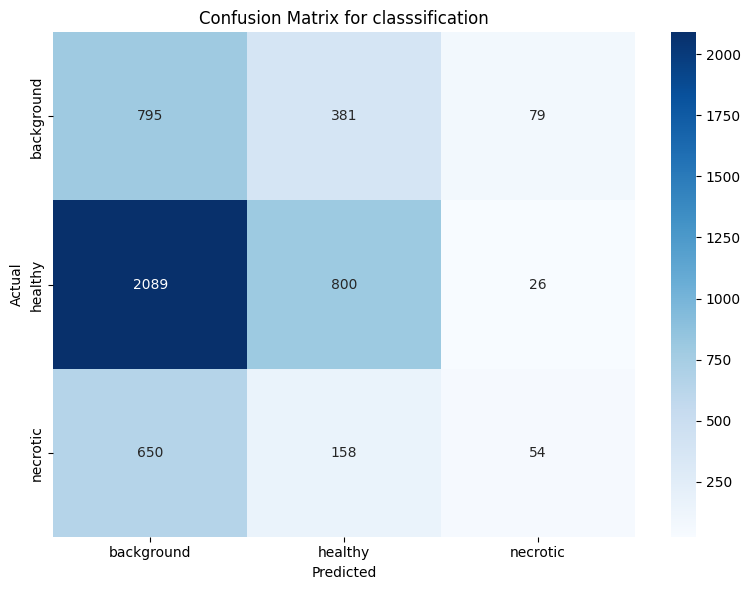

C:\Users\maksi\AppData\Local\Temp\ipykernel_25556\2053745945.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")


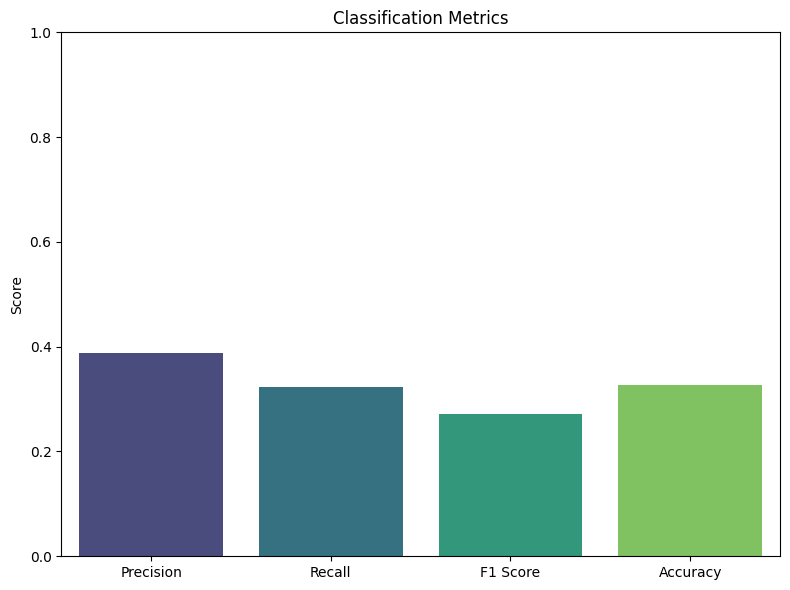

In [23]:
#classify metrics 
precision = precision_score(classify_gt_flat, classify_predictions_flat, average='macro')
recall = recall_score(classify_gt_flat, classify_predictions_flat, average='macro')
f1 = f1_score(classify_gt_flat, classify_predictions_flat, average='macro')
accuracy = accuracy_score(classify_gt_flat, classify_predictions_flat)

cm = confusion_matrix(classify_gt_flat, classify_predictions_flat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(config["classes"].values()),
            yticklabels=list(config["classes"].values()))
plt.title(f'Confusion Matrix for classsification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Graph classify metrics: 
metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Accuracy": accuracy,
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
plt.title("Classification Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
infere_results = coco_detection_evaluator.eval(detect_predictions, names_to_ids, useCats=False)
with open(os.path.join(config['results'], 'detect_coco'), "w") as f:
    json.dump(config, f, indent=4)
    
# Separate AP and AR metrics for better visualization
ap_metrics = {k: v for k, v in infere_results.items() if k.startswith("AP")}
ar_metrics = {k: v for k, v in infere_results.items() if k.startswith("AR")}

# Plot AP metrics
plt.figure(figsize=(8, 6))
sns.barplot(x=list(ap_metrics.keys()), y=list(ap_metrics.values()), palette="coolwarm")
plt.title("Average Precision (AP) Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot AR metrics
plt.figure(figsize=(8, 6))
sns.barplot(x=list(ar_metrics.keys()), y=list(ar_metrics.values()), palette="viridis")
plt.title("Average Recall (AR) Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
area_metrics = {}
for class_id, class_name in config["classes"].items():
    if class_id != 0:
        gt_areas = quantification_gt_flat["areas"][:, class_id]
        pred_areas = quantification_predictions_flat["areas"][:, class_id]
        area_metrics[class_name] = {
            "Explained Variance": explained_variance_score(gt_areas, pred_areas),
            "MAE": mean_absolute_error(gt_areas, pred_areas),
            "R2": r2_score(gt_areas, pred_areas),
            "MAPE": mean_absolute_percentage_error(gt_areas, pred_areas),
        }

all_gt_areas = quantification_gt_flat["areas"][:, 1:].sum(axis=1)
all_pred_areas = quantification_predictions_flat["areas"][:, 1:].sum(axis=1)
area_metrics["All Classes"] = {
    "Explained Variance": explained_variance_score(all_gt_areas, all_pred_areas),
    "MAE": mean_absolute_error(all_gt_areas, all_pred_areas),
    "R2": r2_score(all_gt_areas, all_pred_areas),
    "MAPE": mean_absolute_percentage_error(all_gt_areas, all_pred_areas),
}

for name, metrics in area_metrics.items():
    plt.figure(figsize=(8, 6))
    sns.barplot(x=metrics.keys(), y=metrics.values(), palette="coolwarm")
    plt.title(f"Area Metrics for {name}")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.show()

In [ ]:
count_metrics = {}
for class_id, class_name in config["classes"].items():
    if class_id != 0:
        gt_counts = quantification_gt_flat["counts"][:, class_id]
        pred_counts = quantification_predictions_flat["counts"][:, class_id]
        count_metrics[class_name] = {
            "Explained Variance": explained_variance_score(gt_counts, pred_counts),
            "MAE": mean_absolute_error(gt_counts, pred_counts),
            "R2": r2_score(gt_counts, pred_counts),
            "MAPE": mean_absolute_percentage_error(gt_counts, pred_counts),
        }

all_gt_counts = quantification_gt_flat["counts"][:, 1:].sum(axis=1)
all_pred_counts = quantification_predictions_flat["counts"][:, 1:].sum(axis=1)
count_metrics["All Classes"] = {
    "Explained Variance": explained_variance_score(all_gt_counts, all_pred_counts),
    "MAE": mean_absolute_error(all_gt_counts, all_pred_counts),
    "R2": r2_score(all_gt_counts, all_pred_counts),
    "MAPE": mean_absolute_percentage_error(all_gt_counts, all_pred_counts),
}

for name, metrics in count_metrics.items():
    plt.figure(figsize=(8, 6))
    sns.barplot(x=metrics.keys(), y=metrics.values(), palette="coolwarm")
    plt.title(f"Count Metrics for {name}")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.show()